InstaDeep ML test <br>
Author: Mously Diaw

# Protein sequence classification

Proteins are sequence of amino acids, which can be encoded by a single letter. This project aims at building a deep learning model that assigns amino acid sequences to their protein family. The [Pfam dataset](https://www.kaggle.com/googleai/pfam-seed-random-split) is used for this task. 

1. [Dataset analysis](#section-one) <br>
2. [Classifier](#section-two) <br>
3. [Conclusion](#section-three) <br>

In [77]:
#Import packages
%matplotlib inline
import os
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
#import re 
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder 
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional

<a id="section-one"></a>
# 1. Dataset analysis 

## 1.1. Loading the data

In [78]:
def load_data(partition,col_list):
    data = []
    for fn in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, fn)) as f:
            data.append(pd.read_csv(f, index_col=None,usecols=col_list))
    return pd.concat(data) 

We wish to predict *family_accession* given *sequence* so we will focus on these two attributes.

In [79]:
data_path = '../input/pfam-seed-random-split/random_split/random_split/'
col_list = ["family_accession","sequence"]
df_train = load_data('train',col_list)
df_val = load_data('dev',col_list)
df_test = load_data('test',col_list)

In [80]:
print('Data size:')
print('Train size :', len(df_train))
print('Val size :', len(df_val))
print('Test size :', len(df_test))

Data size:
Train size : 1086741
Val size : 126171
Test size : 126171


In [81]:
df_train.head()

,family_accession,sequence
0,PF08891.11,IEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQGIN...
1,PF01033.17,TTCAVRGCSDINLNQNCQCDPSCYSFGDCCADFAAVCESS
2,PF01805.20,RNIIDKLAQFVARNGPEFEQMTKNKQKDNPKFSFLFGGEYFNYYQYKVT
3,PF06799.11,AVPREQRPVNELQQLKDTPLLAWATLDLPQYAQRLLILYGGVFLLL...
4,PF15494.6,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYNVDTYYYS...


## 1.2. Exploratory data analysis (EDA) and data pre-processing

### 1.2.1. Preliminary processing and EDA

Let's first merge the data.

In [82]:
frames = [df_train, df_val, df_test]
df_full = pd.concat(frames)

In [83]:
print('Total number of unique protein families:',len(df_full.family_accession.unique()))

Total number of unique protein families: 17929


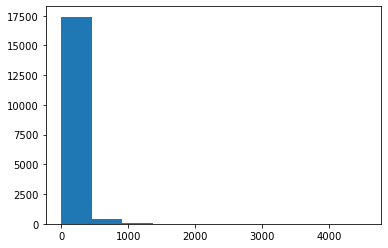

In [93]:
plt.hist(df_full.family_accession.value_counts())
plt.show()

In [100]:
freq_families = df_full.family_accession.value_counts()[df_full.family_accession.value_counts()>500]

Since the data set has over a million samples, we will first work with a sample of it.  

In [103]:
df_partial = df_full.loc[df_full['family_accession'].isin(freq_families.index.tolist())]
len(df_partial)

334045

In [104]:
#n_samples = 12000
#df_partial = df_full.sample(n = n_samples, random_state=1)
num_classes = len(df_partial.family_accession.unique())
print('Number of unique protein families in the sampled data:',num_classes)

Number of unique protein families in the sampled data: 429


We will now compute the number of occurences of each amino acid and the length of the sequences in the training set.

In [105]:
# Count frequency amino acids
keys = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','X', 'U', 'B', 'O', 'Z']

d = {key: 0 for key in keys}
for sequence in df_partial.sequence:     
    for char in sequence: 
        d[char] = d[char] + 1 

# Order by frequency 
d_sorted = sorted(((d[key],key) for key in d), reverse =True) 

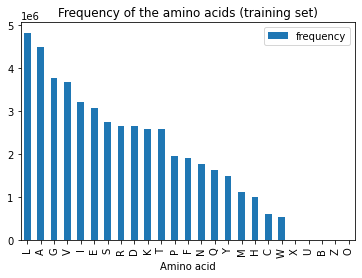

In [106]:
df_freq = pd.DataFrame(d_sorted, columns=['frequency', 'Amino acid'])
df_freq.plot(kind='bar', x='Amino acid')
plt.title("Frequency of the amino acids (training set)")
plt.show() 

We can see that there are 20 common amino acids. X,U,Z,B,O are the least frequent. 

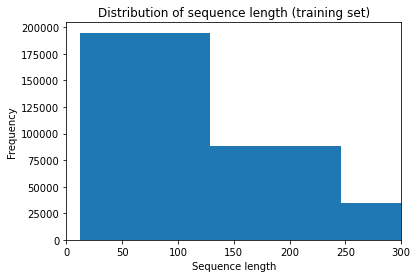

In [107]:
sequence_length = [len(sequence) for sequence in df_partial.sequence]
plt.hist(sequence_length)
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.title('Distribution of sequence length') 
plt.xlim(0, 300) 
plt.show()

The figure above shows that most of the sequences have less than 200 amino acids.  

### 1.2.2. Sequence processing 

Before feeding the data to a neural network, the sequences must be converted into tensors. We chose to tokenize the sequences by breaking them into characters. We then vectorize them (convert each character to a number) using a dictionary with the 20 most common amino acids; the 5 least frequent ones are affected the value '21'. After vectorization, we bring all sequences to the same length before one-hot encoding them. 

In [108]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1
    return char_dict

char_dict = create_dict(amino_acids)

print("Dictionary:", char_dict)

Dictionary: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


In [109]:
def vectorized_sequence(sequence):
    """
    Encodes the sequence using predefined dictionary. The 5 least frequent amino acids are affected the value '21'
    """
    code = []
    l = [char for char in sequence]
    for char in l:
        code.append(char_dict.get(char, 21))    
    return code   

Let's illustrate the process with the following sequence

In [110]:
idx=90
print("Amino acid sequence:",df_partial.sequence.iloc[idx])

Amino acid sequence: KDSTTIDTIRVKYLGKKGELTTILRGMGSLSKEERPIVGKLANEVREVLEAELEAITKAVKEAEKQEKL


In [111]:
vectorized_sequences = [vectorized_sequence(sequence) for sequence in df_partial.sequence]  

In [112]:
print("Vectorized sequence:", vectorized_sequences[idx])

Vectorized sequence: [9, 3, 16, 17, 17, 8, 3, 17, 8, 15, 18, 9, 20, 10, 6, 9, 9, 6, 4, 10, 17, 17, 8, 10, 15, 6, 11, 6, 16, 10, 16, 9, 4, 4, 15, 13, 8, 18, 6, 9, 10, 1, 12, 4, 18, 15, 4, 18, 10, 4, 1, 4, 10, 4, 1, 8, 17, 9, 1, 18, 9, 4, 1, 4, 9, 14, 4, 9, 10]


In [113]:
maxlen = 100
padded_sequences = pad_sequences(vectorized_sequences , maxlen=maxlen, padding='post')

In [114]:
print("Padded sequence:", padded_sequences[idx])

Padded sequence: [ 9  3 16 17 17  8  3 17  8 15 18  9 20 10  6  9  9  6  4 10 17 17  8 10
 15  6 11  6 16 10 16  9  4  4 15 13  8 18  6  9 10  1 12  4 18 15  4 18
 10  4  1  4 10  4  1  8 17  9  1 18  9  4  1  4  9 14  4  9 10  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [115]:
oh_sequences = to_categorical(padded_sequences)

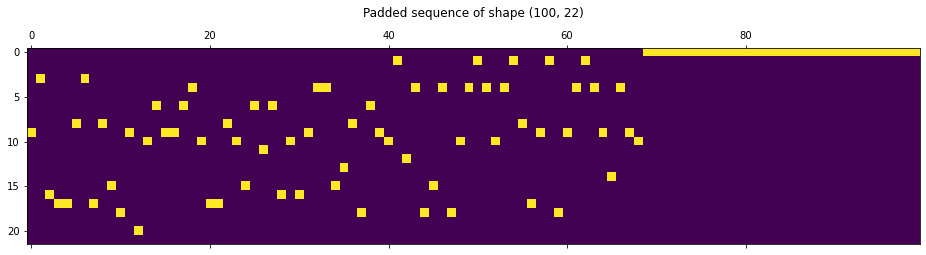

In [116]:
seq = oh_sequences[idx]
plt.matshow(seq.transpose())
plt.title("Padded sequence of shape %s" % (seq.shape,) + "\n")
plt.show()

Finally we will transform the labels by integer encoding. 

In [117]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_partial.family_accession) 

We will split the sampled data into the training, validation and test sets.

In [118]:
X = padded_sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [119]:
print("Length train set:",len(X_train))
print("Length val set:",len(X_val))
print("Length test set:",len(X_test))

Length train set: 270576
Length val set: 30064
Length test set: 33405


<a id="section-two"></a>
# 2. Classifier 

Let's first build a baseline model.

To train the model, we will load the data in batches by creating a data iterator. 

In [120]:
class DataIterator:
    """ Collects data and yields bunch of batches of data
    Takes data sources and batch_size as arguments """
    def _init_(self, data1,data2, batch_size,iters):
        self.data1 = data1
        self.data2 = data2
        self.batch_size = batch_size
        self.iter = iters
        
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X =[self.data1[i] for i in idxs]
        Y =[self.data2[i] for i in idxs]
        X = np.array(X)
        Y = np.array(Y)
        return X, Y
    
    def make_random_iter(self):
        splits = np.arange(self.batch_size, len(self.data1),self.batch_size)
        it = np.split(np.random.permutation(range(len(self.data1))), splits)[:-1]
        return iter(it)

In [121]:
def train_val_model(model,epochs,X_train,y_train,batch_size,X_val,y_val):
    train_iter = DataIterator() 
    train_iter.data1 = X_train
    train_iter.data2 = y_train
    train_iter.batch_size = batch_size
    train_iter.iter = train_iter.make_random_iter()
    training_iters = np.ceil(len(y_train)/train_iter.batch_size)
    acc_epochs =[]
    loss_epochs = []
    val_acc_epochs =[]
    val_loss_epochs = []
    for epoch in range(epochs):  
        print("\n" + "Epoch:",epoch)
        step = 0
        acc = 0
        loss = 0
        val_acc = 0
        val_loss = 0
        while  step  <= training_iters:
            batch_x, batch_y = train_iter.next_batch()
            history = model.fit(batch_x, batch_y , epochs=1,batch_size= train_iter.batch_size, 
                            validation_data=(X_val, y_val),verbose = False) 
            acc += history.history['accuracy'][0] 
            loss += history.history['loss'][0]
            val_acc += history.history['val_accuracy'][0]
            val_loss += history.history['val_loss'][0]
            step += 1
            if step % 50 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, history.history['loss'][0])
                )
                print("Seen so far: %s samples" % ((step) * train_iter.batch_size))
        acc_epochs.append(acc/training_iters) 
        loss_epochs.append(loss/training_iters) 
        val_acc_epochs.append(val_acc/training_iters)
        val_loss_epochs.append(val_loss/training_iters)
    return [acc_epochs,loss_epochs,val_acc_epochs,val_loss_epochs]

In [122]:
model = Sequential([
    Embedding(22, 8, input_length=maxlen),  
    Flatten(),   
    Dense(num_classes, activation ='softmax') 
]) 

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 8)            176       
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 429)               343629    
Total params: 343,805
Trainable params: 343,805
Non-trainable params: 0
_________________________________________________________________


In [123]:
epochs = 15
batch_size = 512
acc_loss = train_val_model(model,epochs,X_train,y_train,batch_size,X_val,y_val)


Epoch: 0
Training loss (for one batch) at step 50: 5.3909
Seen so far: 25600 samples
Training loss (for one batch) at step 100: 3.8170
Seen so far: 51200 samples
Training loss (for one batch) at step 150: 2.1158
Seen so far: 76800 samples
Training loss (for one batch) at step 200: 1.2435
Seen so far: 102400 samples
Training loss (for one batch) at step 250: 0.8706
Seen so far: 128000 samples
Training loss (for one batch) at step 300: 0.5634
Seen so far: 153600 samples
Training loss (for one batch) at step 350: 0.5820
Seen so far: 179200 samples
Training loss (for one batch) at step 400: 0.4414
Seen so far: 204800 samples
Training loss (for one batch) at step 450: 0.3974
Seen so far: 230400 samples
Training loss (for one batch) at step 500: 0.3529
Seen so far: 256000 samples

Epoch: 1
Training loss (for one batch) at step 50: 0.2353
Seen so far: 25600 samples
Training loss (for one batch) at step 100: 0.2269
Seen so far: 51200 samples
Training loss (for one batch) at step 150: 0.2131
S

Training loss (for one batch) at step 300: 0.0012
Seen so far: 153600 samples
Training loss (for one batch) at step 350: 0.0009
Seen so far: 179200 samples
Training loss (for one batch) at step 400: 0.0013
Seen so far: 204800 samples
Training loss (for one batch) at step 450: 0.0009
Seen so far: 230400 samples
Training loss (for one batch) at step 500: 0.0011
Seen so far: 256000 samples

Epoch: 11
Training loss (for one batch) at step 50: 0.0009
Seen so far: 25600 samples
Training loss (for one batch) at step 100: 0.0013
Seen so far: 51200 samples
Training loss (for one batch) at step 150: 0.0007
Seen so far: 76800 samples
Training loss (for one batch) at step 200: 0.0007
Seen so far: 102400 samples
Training loss (for one batch) at step 250: 0.0005
Seen so far: 128000 samples
Training loss (for one batch) at step 300: 0.0044
Seen so far: 153600 samples
Training loss (for one batch) at step 350: 0.0007
Seen so far: 179200 samples
Training loss (for one batch) at step 400: 0.0009
Seen so

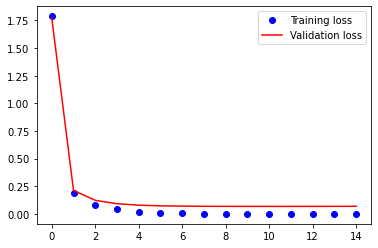

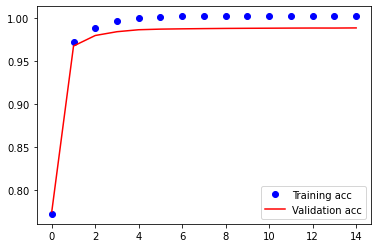

In [124]:
epochs = range(1, len(acc_loss) + 1) 
plt.plot(acc_loss[1], 'bo', label='Training loss')  
plt.plot(acc_loss[3], 'r', label='Validation loss')
plt.legend() 
plt.figure() 
plt.plot(acc_loss[0], 'bo', label='Training acc') 
plt.plot(acc_loss[2], 'r', label='Validation acc') 
plt.legend() 
plt.show() 

In [126]:
results = model.evaluate(X_test, y_test)
print("test loss, test accuracy:", results)

1044/1044 [==============================] - 2s 2ms/step - loss: 0.0720 - accuracy: 0.9862
test loss, test accuracy: [0.07195643335580826, 0.9862295985221863]


<a id="section-three"></a>
# Conclusion
**^html link hidden here, fork notebook then click this cell to see it**

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Sed velit dignissim sodales ut eu sem integer vitae. Quam vulputate dignissim suspendisse in est ante. Arcu non odio euismod lacinia at. Etiam tempor orci eu lobortis. Egestas sed sed risus pretium quam vulputate dignissim suspendisse. Magna eget est lorem ipsum dolor sit amet consectetur adipiscing. Eget velit aliquet sagittis id consectetur purus ut faucibus. Egestas quis ipsum suspendisse ultrices gravida dictum fusce ut. Sed pulvinar proin gravida hendrerit. Dui faucibus in ornare quam viverra. Elit ullamcorper dignissim cras tincidunt lobortis feugiat vivamus. Enim diam vulputate ut pharetra sit amet aliquam. Nec feugiat in fermentum posuere urna nec tincidunt praesent. Elementum nisi quis eleifend quam adipiscing vitae proin sagittis. Malesuada proin libero nunc consequat interdum varius sit amet mattis. Urna neque viverra justo nec ultrices dui sapien. Adipiscing tristique risus nec feugiat in. Habitant morbi tristique senectus et netus et malesuada.